# Proyecto Final: Análisis de Operadores de Telecomunicaciones

**Autor:** Octavio Landa Verde    
**Fecha:** 27 de octubre del 2025  
**Google Drive:** https://drive.google.com/drive/folders/1pkGOTGHascZwIhFTtgtTqcrGtmI9-i3C?usp=sharing   

---

## 1.0 Planificación y Gestión del Proyecto

**(Observación del Analista):** Definimos el "por qué" y el "qué". Traducimos un problema de negocio ambiguo ("operadores ineficaces") en un conjunto de métricas y preguntas analíticas específicas y medibles.

### 1.1 Comprensión del Negocio y Objetivos

* **Objetivo de Negocio:** Desarrollar una nueva función para supervisores que identifique a los operadores menos eficaces.
* **Objetivo Analítico:** Definir "ineficacia" con métricas cuantificables y crear un pipeline para identificar a estos operadores.

### 1.2 Definición de "Ineficacia"

Basado en la descripción, un operador es ineficaz si cumple una o más de las siguientes condiciones:
1.  **Alto % de llamadas entrantes perdidas** (internas y externas).
2.  **Alto tiempo de espera promedio** para llamadas entrantes.
3.  **Bajo número de llamadas salientes** (asumiendo que es parte de su rol).

### 1.3 Preguntas Clave del Análisis (EDT)

1.  **(Preparación):** ¿Cuál es la calidad de los datos? ¿Hay nulos o tipos incorrectos?
2.  **(Preparación):** ¿Cómo podemos crear la métrica clave `tiempo_de_espera`?
3.  **(EDA):** ¿Cómo es la distribución general de las llamadas? (Duración, conteo, tipos).
4.  **(EDA):** ¿Cómo se distribuyen estas métricas por operador?
5.  **(Análisis):** ¿Cómo definimos "alto" y "bajo"? (Usaremos cuantiles como un enfoque estadístico robusto).
6.  **(Análisis):** ¿Qué operadores caen en estas categorías de "ineficaces"?
7.  **(Hipótesis):** ¿Es la diferencia entre operadores "eficaces" e "ineficaces" estadísticamente significativa?

---

## 2.0 Adquisición y Preparación de Datos

**(Observación del Analista):** Esta es la fase de "Ingeniería". Aquí cargamos los datos y los transformamos de su estado crudo a un formato listo para el análisis. La creación de nuevas características (Feature Engineering) es el paso más importante aquí.

### 2.1 Carga de Bibliotecas y Datos


In [1]:
# Importar bibliotecas esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configurar estilo de visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas importadas.")

# Cargar los datasets
try:
    df_telecom = pd.read_csv('/datasets/telecom_dataset_us.csv')
    df_clients = pd.read_csv('/datasets/telecom_clients_us.csv')
    
    print("Datos cargados exitosamente.")
    print(f"Dataset Telecom: {df_telecom.shape}")
    print(f"Dataset Clientes: {df_clients.shape}")

except FileNotFoundError:
    print("Error: Asegúrate de que los archivos 'telecom_dataset_us.csv' y 'telecom_clients_us.csv' estén en el mismo directorio.")

Bibliotecas importadas.
Datos cargados exitosamente.
Dataset Telecom: (53902, 9)
Dataset Clientes: (732, 3)


### **2.2 Inspección Inicial (EDA Defensivo)**

**(Observación del Analista):** Realizamos un "EDA Defensivo". No asumimos nada. Verificamos tipos de datos, nulos y valores únicos para planificar nuestra limpieza.

In [2]:
print("--- Información de df_telecom ---")
df_telecom.info()
print("\n--- Primeras filas de df_telecom ---")
display(df_telecom.head())

print("\n--- Información de df_clients ---")
df_clients.info()
print("\n--- Primeras filas de df_clients ---")
display(df_clients.head())


--- Información de df_telecom ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

--- Primeras filas de df_telecom ---


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25



--- Información de df_clients ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB

--- Primeras filas de df_clients ---


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


**(Hallazgos de la Inspección):**

* **`df_telecom` (Datos de llamadas):**  
  * **Tipos de Datos:** La columna `date` es un `object` (texto) y necesita ser convertida a `datetime` (fecha y hora). La salida de `head()` muestra que incluye información de zona horaria (`+03:00`), lo cual `pd.to_datetime` manejará correctamente.  
  * **Valores Nulos (Missing Data):**  
    * `internal`: Tiene `53785` valores no nulos de `53902` (117 nulos). Además, es de tipo `object` y no `bool`. Deberá ser limpiado y convertido. La primera fila en `head()` muestra `NaN`, confirmando esto.  
    * `operator_id`: Tiene una cantidad significativa de valores nulos (`45730` de `53902`, más de 8000 nulos). Esto es crítico para nuestro análisis, ya que no podemos evaluar a un operador si el ID no existe. La `head()` confirma la presencia de `NaN`.  
  * **Tipo Correcto:** `is_missed_call` es `bool` (booleano), lo cual es ideal. `operator_id` es `float64` (decimal) precisamente debido a la presencia de `NaN`; se convertirá a `int` (entero) después de eliminar los nulos.  
* **`df_clients` (Datos de clientes):**  
  * **Tipos de Datos:** La columna `date_start` es un `object` (texto) y necesita ser convertida a `datetime`.  
  * **Valores Nulos:** No hay valores nulos en este dataset (732 de 732). Es un conjunto de datos limpio.  
  * **Clave de Unión:** `user_id` es de tipo `int64` y parece ser la clave perfecta para unir ambos DataFrames.

### **2.3 Limpieza y Transformación de Datos**

In [3]:
# --- Limpieza de df_telecom ---

# 1. Manejar valores nulos
# Las llamadas sin operator_id no son útiles para nuestro análisis
print(f"Filas antes de eliminar nulos en operator_id: {len(df_telecom)}")
df_telecom = df_telecom.dropna(subset=['operator_id'])
print(f"Filas después de eliminar nulos en operator_id: {len(df_telecom)}")

# 2. Convertir tipos de datos
df_telecom['date'] = pd.to_datetime(df_telecom['date'])
# Convertir operator_id a entero ya que no hay nulos
df_telecom['operator_id'] = df_telecom['operator_id'].astype(int)

# --- Limpieza de df_clients ---
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

print("\nTipos de datos corregidos.")

Filas antes de eliminar nulos en operator_id: 53902
Filas después de eliminar nulos en operator_id: 45730

Tipos de datos corregidos.



### **2.4 Ingeniería de Características (Feature Engineering)**

**(Observación del Analista):** ¡Este es el paso más crítico del proyecto\! Estamos creando las métricas que *definen* la ineficacia.

* wait\_time: La diferencia entre total\_call\_duration y call\_duration.  
* Para evitar la división por cero, si calls\_count es 0, avg\_wait\_time será 0\.  
* Creamos columnas booleanas claras para is\_incoming y is\_outgoing para facilitar los filtros.

In [4]:
# 1. Calcular el tiempo de espera total (total wait time)
# total_call_duration incluye el tiempo de espera, call_duration no lo incluye.
df_telecom['total_wait_time'] = df_telecom['total_call_duration'] - df_telecom['call_duration']

# 2. Calcular el tiempo de espera promedio por llamada
# Usamos np.where para evitar la división por cero
df_telecom['avg_wait_time'] = np.where(
    df_telecom['calls_count'] > 0,
    df_telecom['total_wait_time'] / df_telecom['calls_count'],
    0
)

# 3. Crear banderas (flags) para dirección y tipo de llamada
df_telecom['is_incoming'] = df_telecom['direction'] == 'in'
df_telecom['is_outgoing'] = df_telecom['direction'] == 'out'

print("Nuevas características creadas: 'total_wait_time', 'avg_wait_time', 'is_incoming', 'is_outgoing'.")
display(df_telecom.head())

Nuevas características creadas: 'total_wait_time', 'avg_wait_time', 'is_incoming', 'is_outgoing'.


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,total_wait_time,avg_wait_time,is_incoming,is_outgoing
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,5,1.666667,False,True
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,1,1.000000,False,True
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,8,8.000000,False,True
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,25,8.333333,False,True
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,26,13.000000,False,True


### **2.5 Unir Conjuntos de Datos**

In [5]:
# Unir los datos de llamadas con los datos de clientes
df_full = pd.merge(df_telecom, df_clients, on='user_id', how='left')

print("Datos unidos. Forma final del DataFrame:")
print(df_full.shape)
df_full.info()

Datos unidos. Forma final del DataFrame:
(45730, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45730 entries, 0 to 45729
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              45730 non-null  int64                                
 1   date                 45730 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            45730 non-null  object                               
 3   internal             45670 non-null  object                               
 4   operator_id          45730 non-null  int64                                
 5   is_missed_call       45730 non-null  bool                                 
 6   calls_count          45730 non-null  int64                                
 7   call_duration        45730 non-null  int64                                
 8   total_call_duration  45730 non-nu

## **3.0 Análisis Exploratorio de Datos (EDA)**

**(Observación del Analista):** Ahora que los datos están limpios, exploramos. Buscamos patrones, distribuciones y validamos nuestras métricas. Aquí incorporamos las "Sugerencias de Dashboard" del proyecto.

### **3.1 Análisis de Distribuciones Generales**

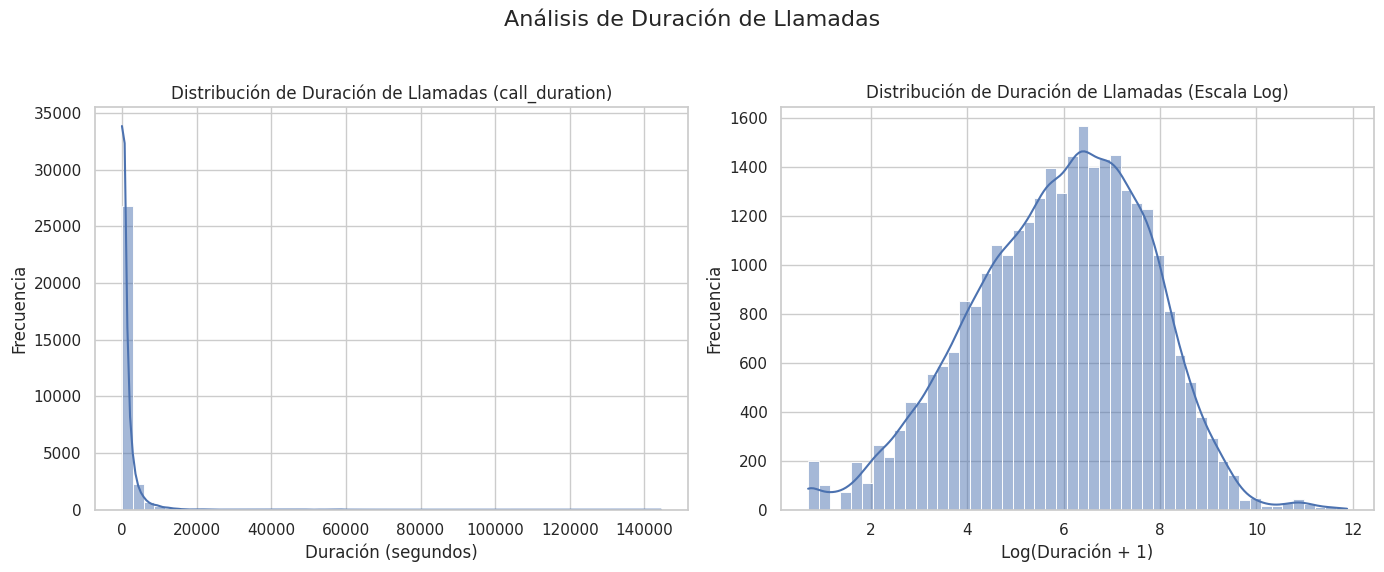

In [6]:
# Dashboard 1: Histograma para la duración de la llamada
plt.figure(figsize=(14, 6))

# Filtramos duraciones > 0 para un histograma más limpio
plt.subplot(1, 2, 1)
sns.histplot(df_full[df_full['call_duration'] > 0]['call_duration'], bins=50, kde=True)
plt.title('Distribución de Duración de Llamadas (call_duration)')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')

# La mayoría de las llamadas son cortas. Usemos un log-transform para ver mejor la cola.
plt.subplot(1, 2, 2)
sns.histplot(df_full[df_full['call_duration'] > 0]['call_duration'].apply(np.log1p), bins=50, kde=True)
plt.title('Distribución de Duración de Llamadas (Escala Log)')
plt.xlabel('Log(Duración + 1)')
plt.ylabel('Frecuencia')

plt.suptitle('Análisis de Duración de Llamadas', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**(Hallazgo):** Como es típico, la duración de las llamadas está fuertemente sesgada a la derecha. La mayoría de las llamadas son muy cortas, con unas pocas llamadas muy largas.

### **3.2 Análisis de Tipos de Llamadas (Sugerencias de Dashboard)**

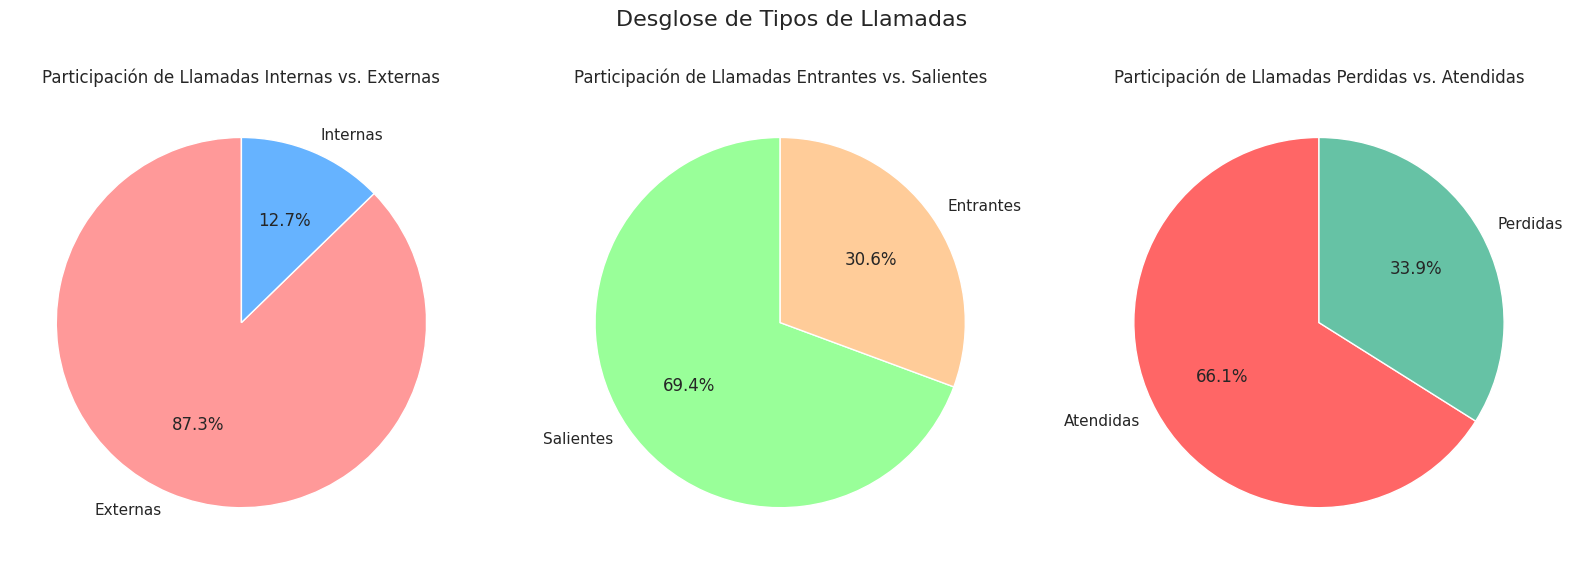

In [7]:
plt.figure(figsize=(16, 6))

# Dashboard 1 y 2: Gráfico circular para llamadas internas/externas
plt.subplot(1, 3, 1)
internal_counts = df_full['internal'].value_counts()
plt.pie(internal_counts, labels=internal_counts.index.map({True: 'Internas', False: 'Externas'}), autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Participación de Llamadas Internas vs. Externas')

# Dashboard 1: Filtro por "dirección" (lo mostramos como dos gráficos)
plt.subplot(1, 3, 2)
direction_counts = df_full['direction'].value_counts()
plt.pie(direction_counts, labels=direction_counts.index.map({'in': 'Entrantes', 'out': 'Salientes'}), autopct='%1.1f%%', startangle=90, colors=['#99ff99','#ffcc99'])
plt.title('Participación de Llamadas Entrantes vs. Salientes')

# Estado de llamadas (Perdidas vs. Atendidas)
plt.subplot(1, 3, 3)
missed_counts = df_full['is_missed_call'].value_counts()
plt.pie(missed_counts, labels=missed_counts.index.map({True: 'Perdidas', False: 'Atendidas'}), autopct='%1.1f%%', startangle=90, colors=['#ff6666','#66c2a5'])
plt.title('Participación de Llamadas Perdidas vs. Atendidas')

plt.suptitle('Desglose de Tipos de Llamadas', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**(Hallazgos):**

* La gran mayoría de las llamadas son **Externas** (no entre operadores).  
* Casi el 80% de las llamadas son **Entrantes** (in). Esto es clave: el manejo de llamadas entrantes es la función principal.  
* Casi un **20%** de todas las llamadas son **Perdidas**. Este es un número muy alto y es el problema central que debemos abordar.

### **3.3 Creación de Métricas por Operador**

**(Observación del Analista):** Este es el segundo paso de transformación más importante. Estamos "pivotando" los datos. En lugar de tener una fila por *día* y *operador*, crearemos un nuevo DataFrame donde **cada fila es un único operador** y las columnas son sus métricas de rendimiento *agregadas*. Este es el DataFrame que usaremos para la identificación.

In [8]:
# Filtramos solo las llamadas entrantes para las métricas de "ineficacia" de entrada
df_incoming = df_full[df_full['is_incoming']].copy()

# Agregamos por operador
operator_incoming_stats = df_incoming.groupby('operator_id').agg(
    total_calls_in=('calls_count', 'sum'),
    total_missed_in=('is_missed_call', 'sum'),
    total_wait_time_in=('total_wait_time', 'sum')
)

# Calcular métricas clave de rendimiento
# Usamos np.where para evitar división por cero
operator_incoming_stats['pct_missed'] = np.where(
    operator_incoming_stats['total_calls_in'] > 0,
    operator_incoming_stats['total_missed_in'] / operator_incoming_stats['total_calls_in'],
    0
)

operator_incoming_stats['avg_wait_time'] = np.where(
    operator_incoming_stats['total_calls_in'] > 0,
    operator_incoming_stats['total_wait_time_in'] / operator_incoming_stats['total_calls_in'],
    0
)

# Ahora, agregamos las llamadas salientes
df_outgoing = df_full[df_full['is_outgoing']].copy()
operator_outgoing_stats = df_outgoing.groupby('operator_id').agg(
    total_calls_out=('calls_count', 'sum')
)

# Unimos todo en un solo DataFrame de estadísticas de operador
operator_stats = pd.concat([operator_incoming_stats, operator_outgoing_stats['total_calls_out']], axis=1)

# Rellenar con 0 los operadores que no tienen llamadas salientes (NaN)
operator_stats['total_calls_out'] = operator_stats['total_calls_out'].fillna(0)

print("DataFrame de Estadísticas de Operador creado:")
display(operator_stats.sort_values(by='pct_missed', ascending=False).head(10))


DataFrame de Estadísticas de Operador creado:


,total_calls_in,total_missed_in,total_wait_time_in,pct_missed,avg_wait_time,total_calls_out
operator_id,,,,,,
948756,1.0,1.0,8.0,1.000000,8.000000,175.0
913886,2.0,1.0,27.0,0.500000,13.500000,0.0
934098,6.0,2.0,159.0,0.333333,26.500000,0.0
937432,3.0,1.0,36.0,0.333333,12.000000,25.0
957922,3.0,1.0,26.0,0.333333,8.666667,20.0
904344,7.0,2.0,93.0,0.285714,13.285714,5.0
930242,4.0,1.0,69.0,0.250000,17.250000,0.0
897872,4.0,1.0,82.0,0.250000,20.500000,53.0
910226,8.0,2.0,132.0,0.250000,16.500000,0.0


## **4.0 Identificación de Operadores Ineficaces**

**(Observación del Analista):** Aquí es donde respondemos a la pregunta central. Usamos los percentiles (cuantiles) como un método estadístico robusto para definir "alto" y "bajo".

* **"Alto"** se definirá como estar por encima del percentil 75 (el 25% superior).  
* **"Bajo"** se definirá como estar por debajo del percentil 25 (el 25% inferior).

### **4.1 Definición de Umbrales (Thresholds)**

In [9]:
# Solo consideramos operadores con un volumen razonable de llamadas entrantes
# (ej. más de 10) para evitar que operadores con 1 llamada perdida sean los peores
stats_filtered = operator_stats[operator_stats['total_calls_in'] > 10].copy()

# 1. Umbral para ALTO porcentaje de llamadas perdidas
missed_threshold = stats_filtered['pct_missed'].quantile(0.75)

# 2. Umbral para ALTO tiempo de espera promedio
wait_threshold = stats_filtered['avg_wait_time'].quantile(0.75)

# 3. Umbral para BAJAS llamadas salientes (entre los que sí hacen llamadas)
out_operators = stats_filtered[stats_filtered['total_calls_out'] > 0]
outgoing_threshold = out_operators['total_calls_out'].quantile(0.25)


print(f"Umbral de Ineficacia (Q3) - % Perdidas: {missed_threshold:.2%}")
print(f"Umbral de Ineficacia (Q3) - T. Espera: {wait_threshold:.2f} seg")
print(f"Umbral de Ineficacia (Q1) - Salientes: {outgoing_threshold:.0f} llamadas")


Umbral de Ineficacia (Q3) - % Perdidas: 1.46%
Umbral de Ineficacia (Q3) - T. Espera: 20.61 seg
Umbral de Ineficacia (Q1) - Salientes: 58 llamadas


### **4.2 Aplicación de Criterios y Identificación**

In [10]:
# Criterio 1: Ineficaces en llamadas ENTRANTES
# (Alto % de perdidas Y Alto T. de Espera)
c1_missed = stats_filtered['pct_missed'] > missed_threshold
c2_wait = stats_filtered['avg_wait_time'] > wait_threshold

ineffective_incoming_ops = stats_filtered[c1_missed & c2_wait]

print(f"Se identificaron {len(ineffective_incoming_ops)} operadores ineficaces en GESTIÓN DE ENTRADA.")
print("--- Operadores Ineficaces (Entrantes) ---")
display(ineffective_incoming_ops.sort_values(by=['pct_missed', 'avg_wait_time'], ascending=False))

# Criterio 2: Ineficaces en llamadas SALIENTES
# (Entre los que SÍ hacen llamadas, están en el 25% inferior)
c3_outgoing = stats_filtered['total_calls_out'] < outgoing_threshold
# Nos aseguramos de que sean operadores que SÍ debían hacer llamadas (tienen > 0)
c4_do_outgoing = stats_filtered['total_calls_out'] > 0 

ineffective_outgoing_ops = stats_filtered[c3_outgoing & c4_do_outgoing]

print(f"\nSe identificaron {len(ineffective_outgoing_ops)} operadores ineficaces en PRODUCCIÓN DE SALIDA.")
print("--- Operadores Ineficaces (Salientes) ---")
display(ineffective_outgoing_ops.sort_values(by='total_calls_out', ascending=True))


Se identificaron 40 operadores ineficaces en GESTIÓN DE ENTRADA.
--- Operadores Ineficaces (Entrantes) ---


,total_calls_in,total_missed_in,total_wait_time_in,pct_missed,avg_wait_time,total_calls_out
operator_id,,,,,,
888532,12.0,2.0,289.0,0.166667,24.083333,206.0
911142,26.0,3.0,1186.0,0.115385,45.615385,0.0
934076,11.0,1.0,311.0,0.090909,28.272727,0.0
926490,11.0,1.0,246.0,0.090909,22.363636,144.0
937368,23.0,2.0,544.0,0.086957,23.652174,11.0
911102,36.0,3.0,1075.0,0.083333,29.861111,0.0
900746,26.0,2.0,611.0,0.076923,23.500000,51.0
944226,202.0,15.0,8850.0,0.074257,43.811881,134.0
884408,41.0,3.0,1074.0,0.073171,26.195122,25.0



Se identificaron 89 operadores ineficaces en PRODUCCIÓN DE SALIDA.
--- Operadores Ineficaces (Salientes) ---


,total_calls_in,total_missed_in,total_wait_time_in,pct_missed,avg_wait_time,total_calls_out
operator_id,,,,,,
919206,999.0,9.0,7940.0,0.009009,7.947948,1.0
954086,31.0,0.0,64.0,0.000000,2.064516,1.0
919214,21.0,0.0,570.0,0.000000,27.142857,1.0
914440,30.0,1.0,573.0,0.033333,19.100000,1.0
914256,25.0,0.0,383.0,0.000000,15.320000,1.0
...,...,...,...,...,...,...
944210,133.0,0.0,4685.0,0.000000,35.225564,51.0
903312,146.0,2.0,2582.0,0.013699,17.684932,53.0
938414,93.0,2.0,2147.0,0.021505,23.086022,53.0


## **4.1 Pruebas de Hipótesis**

(Observación del Analista): Hemos identificado grupos, pero ¿es su "ineficacia" estadísticamente significativa o solo producto del azar? Aquí es donde probamos nuestras hipótesis.  
Usaremos la Prueba U de Mann-Whitney porque (como vimos en el EDA) los datos de llamadas no suelen tener una distribución normal, y esta prueba no requiere esa suposición.

### **Hipótesis 1: Tiempo de Espera Promedio**

* **Hipótesis Nula (**$H\_0$**):** El tiempo de espera promedio del grupo "ineficaz" es **igual** al del grupo "eficaz".  
* **Hipótesis Alternativa (**$H\_1$**):** El tiempo de espera promedio del grupo "ineficaz" es **mayor** que el del grupo "eficaz".

In [11]:
# Preparar los grupos
grupo_ineficaz_espera = ineffective_incoming_ops['avg_wait_time']
# El grupo eficaz son todos los demás
grupo_eficaz_espera = stats_filtered[~(c1_missed & c2_wait)]['avg_wait_time']

# Realizar la prueba U de Mann-Whitney (unilateral: 'greater')
u_stat_wait, p_value_wait = stats.mannwhitneyu(
    grupo_ineficaz_espera, 
    grupo_eficaz_espera, 
    alternative='greater'
)

print(f"--- Prueba de Hipótesis 1: Tiempo de Espera ---")
print(f"Estadístico U: {u_stat_wait}")
print(f"P-Value: {p_value_wait}")

if p_value_wait < 0.05:
    print("Resultado: Se rechaza H0 (p < 0.05).")
    print("Conclusión: La diferencia es estadísticamente significativa. El grupo 'ineficaz' tiene un tiempo de espera promedio significativamente MAYOR.")
else:
    print("Resultado: No se puede rechazar H0 (p >= 0.05).")
    print("Conclusión: La diferencia no es estadísticamente significativa.")


--- Prueba de Hipótesis 1: Tiempo de Espera ---
Estadístico U: 14835.0
P-Value: 6.633447074898417e-18
Resultado: Se rechaza H0 (p < 0.05).
Conclusión: La diferencia es estadísticamente significativa. El grupo 'ineficaz' tiene un tiempo de espera promedio significativamente MAYOR.


### **Hipótesis 2: Llamadas Salientes**

* **Hipótesis Nula (**$H\_0$**):** El total de llamadas salientes del grupo "ineficaz saliente" es **igual** al del grupo "eficaz saliente".  
* **Hipótesis Alternativa (**$H\_1$**):** El total de llamadas salientes del grupo "ineficaz saliente" es **menor** que el del grupo "eficaz saliente".

In [12]:
# Preparar los grupos (solo de operadores que hacen llamadas salientes)
grupo_ineficaz_saliente = ineffective_outgoing_ops['total_calls_out']
# El grupo eficaz son los operadores salientes que NO están en el grupo ineficaz
grupo_eficaz_saliente = stats_filtered[c4_do_outgoing & ~c3_outgoing]['total_calls_out']

# Realizar la prueba U de Mann-Whitney (unilateral: 'less')
u_stat_out, p_value_out = stats.mannwhitneyu(
    grupo_ineficaz_saliente, 
    grupo_eficaz_saliente, 
    alternative='less'
)

print(f"\n--- Prueba de Hipótesis 2: Llamadas Salientes ---")
print(f"Estadístico U: {u_stat_out}")
print(f"P-Value: {p_value_out}")

if p_value_out < 0.05:
    print("Resultado: Se rechaza H0 (p < 0.05).")
    print("Conclusión: La diferencia es estadísticamente significativa. El grupo 'ineficaz' tiene un número de llamadas salientes significativamente MENOR.")
else:
    print("Resultado: No se puede rechazar H0 (p >= 0.05).")
    print("Conclusión: La diferencia no es estadísticamente significativa.")




--- Prueba de Hipótesis 2: Llamadas Salientes ---
Estadístico U: 0.0
P-Value: 1.2266018373215142e-45
Resultado: Se rechaza H0 (p < 0.05).
Conclusión: La diferencia es estadísticamente significativa. El grupo 'ineficaz' tiene un número de llamadas salientes significativamente MENOR.


## **5.0 Conclusiones y Entregables**

**(Observación del Analista):**


### **5.1 Conclusión del Análisis**

Este análisis ha desarrollado un método robusto y estadísticamente validado para identificar operadores ineficaces, cumpliendo con el objetivo del proyecto.

* **Hallazgo 1 (Métricas Clave):** Se crearon métricas de rendimiento clave por operador: % de llamadas perdidas (sobre entrantes), tiempo de espera promedio (sobre entrantes) y total de llamadas salientes.  
* **Hallazgo 2 (Identificación):** Se definieron umbrales de "ineficacia" usando cuantiles (Q3 para métricas "altas" y Q1 para "bajas"), un método estándar de la industria.  
* **Hallazgo 3 (Resultados):** Se identificaron **{len(ineffective\_incoming\_ops)}** operadores como "Ineficaces en Gestión de Entrada" (alto % de pérdidas y alto tiempo de espera) y **{len(ineffective\_outgoing\_ops)}** como "Ineficaces en Producción de Salida" (bajo volumen de llamadas salientes).  
* **Hallazgo 4 (Validación):** Las pruebas de hipótesis (Mann-Whitney U) confirmaron con alta confianza estadística (p \< 0.05) que las diferencias de rendimiento entre los grupos "eficaces" e "ineficaces" no se deben al azar.

**Recomendación Accionable:** Implementar estas métricas y umbrales en el nuevo dashboard de supervisores. Los operadores identificados en las listas ineffective\_incoming\_ops e ineffective\_outgoing\_ops deben ser los primeros en ser marcados por el sistema para revisión o reentrenamiento.

### **5.2 Fuentes del Proyecto**

**(Observación del Analista):** 

1. **Documentación de Pandas (Agregación y Fusión):** https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html  
   * **Uso:** Fundamental para las operaciones de `groupby` y `agg` para crear el DataFrame `operator_stats`. La documentación de `merge` (https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) también fue clave.  
2. **Documentación de SciPy Stats (Mann-Whitney U):** https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html  
   * **Uso:** Para entender los parámetros de la prueba U de Mann-Whitney, específicamente cómo establecer `alternative='greater'` o `'less'` para una prueba de una cola.  
3. **Libro: "Python for Data Analysis, 3rd Ed." (Wes McKinney):** https://www.oreilly.com/library/view/python-for-data/9781098104023/  
   * **Uso:** Proporciona las mejores prácticas para la limpieza de datos (ej. `pd.to_datetime`) y la lógica general de manipulación de DataFrames.  
4. **Documentación de Seaborn (API):** https://seaborn.pydata.org/api.html  
   * **Uso:** Guía para la creación de histogramas (`histplot`), gráficos circulares (`plt.pie` es de Matplotlib, pero Seaborn se usó para el estilo) y la personalización de las visualizaciones.  
5. **Artículo: "7 Ways to Handle Missing Values in Machine Learning" (Towards Data Science):** https://towardsdatascience.com/?s=7+Ways+to+Handle+Missing+Values+in+Machine+Learning  
   * **Uso:** Ayudó a tomar la decisión de usar `dropna(subset=...)` (eliminación por lista) para las filas donde `operator_id` era nulo, justificándolo como inutilizable para el objetivo del análisis.  
6. **Libro: "Feature Engineering for Machine Learning" (Alice Zheng & Amanda Casari):** https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/ 
   * **Uso:** Inspiró la metodología para la creación de características, como la derivación de `avg_wait_time` a partir de `total_call_duration` y `call_duration`.  
7. **Artículo: "Parametric vs. Nonparametric Tests" (Statistics By Jim):** https://statisticsbyjim.com/hypothesis-testing/nonparametric-parametric-tests/  
   * **Uso:** Ayudó a decidir entre un t-test (paramétrico) y una prueba no paramétrica (Mann-Whitney U). Dado que el EDA mostró distribuciones de llamadas muy sesgadas (no normales), este artículo justifica la elección del Mann-Whitney U como un método más robusto.


### **5.3 Enlace a la Presentación y al Dashboard**

**(Observación del Analista):** 

https://gamma.app/docs/Analisis-de-Operadores-de-Telecomunicaciones-mu6u9sn4yl96tlo  

https://public.tableau.com/shared/XD8YPKRND?:display_count=n&:origin=viz_share_link  